# Trabajo Pracico N3 - Performance

## Enrique C. Toomey

Objetivos:

1) Con los datos disponibles del helicóptero modelo representar la potencia reducida en función de la velocidad adimensional de vuelo (o de la relación de avance) a nivel del mar y a alturas diversas

2) Estimar la velocidad de mínima potencial y evaluar la variación con la altura

3) Estimar la velocidad de máximo alcance

4) Estimar la velocidad de descenso en autorotación en avance y la velocidad de vuelo en avance correspondiente

5) Estimar la velocidad de ascenso a nivel del mar desde punto fijo, y para $\mu = [0.1,~0.2,~0.3,~0.4,~0.5]$. Comentar por que resulta mayor a $\mu\neq 0$

6) Estimar el tiempo de punto fijo equivalente para autorotación

7) Evaluar en base a la tabla para autorotación la cualidad de la aeronave en esta actuación.

8) Comentar los resultados obtenidos en base a la comparación con los datos informados por el fabricante.

In [1]:
import sys
sys.path.append('C:\\Users\\enri\\PYTHON_PROJECTS\\Helicopteros')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import atmosfera_estandar
from scipy import interpolate
import helicopter as Helicopter
%matplotlib inline

Datos de entrada

In [3]:
gravity = 9.81 #[m/s**2]
temp = 15 + 273 # Sea level temperature
height = [0, 1000.0, 2000.0, 3000.0, 4000.0]
density = [atmosfera_estandar.atmosfera_estandar('altura',h)[4] for h in height]
temperature = [atmosfera_estandar.atmosfera_estandar('altura',h)[3] for h in height]
vel_son = [atmosfera_estandar.atmosfera_estandar('altura',h)[6] for h in height]

In [4]:
airfoil_name = 'NACA 0012'
a2d = 6 # [1/rad] airfoil Cl vs alpha slope
alpha_perdida = 9*np.pi/180.0
airfoil = Helicopter.Airfoil(name=airfoil_name, a2d=a2d, alpha_perdida=alpha_perdida)
blade_length = 7.7/2.0;
chord = 0.183 # [m]
twist = -7 * np.pi / 180.0 # [rad]
Fp = 0.97 # Blade's tip loss factor
Cd0 = 0.01035 # Mean Resistance coeficient
blade = Helicopter.Helicopter.Rotor.Blade(airfoil=airfoil, length=blade_length, chord=chord,
                               twist=twist, blade_tip_lost_factor=Fp, cd0=Cd0)
n_blades = 2
inertia_rotor = 36.4 #[kg m**2]
angular_velocity = 55.56 # [rad/s]
rotor = Helicopter.Helicopter.Rotor(blade=blade, number_of_blades=n_blades,
                         inertia=inertia_rotor, angular_velocity=angular_velocity)
weight = 590 # [kg]
helicopter = Helicopter.Helicopter(rotor=rotor, weight=weight)

In [5]:
mu = np.arange(0,0.51,0.01)#[0, 0.1, 0.2, 0.3, 0.4] # Relación de avance
velocity = [mu_val * helicopter.rotor.angular_velocity * helicopter.rotor.radius for mu_val in mu]
mu_points = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
vel_points = [mu_val * helicopter.rotor.angular_velocity * helicopter.rotor.radius for mu_val in mu_points]

vel_ind_0 = [helicopter.velocidad_inducida_0(den) for den in density]
lambda_ind_0 = [helicopter.lambda_inducido_0(den) for den in density] # Relación de flujo inducido
vel_ind = [[helicopter.velocidad_inducida(vel,den) for vel in velocity] for den in density]

## 1) calculo de la potencia reducidad

### Potencia inducida

Calculamos la potencia inducida a partir de la velocidad inducida en función de la velocidad de avance $v_{\infty}$ y la velocidad inducida en vuelo en punto fijo ${v_i}_0$, que a su ves depende de la altura $h$
.
$$v_i(v_{\infty},h)={v_i}_0(h) \cdot \sqrt{ \sqrt{ 1 + \frac{1}{4} \left(\frac{v_{\infty}}{{v_i}_0(h)}\right)^{4}} - \frac{1}{2} \left(\frac{ v_{\infty} }{ {v_i}_0(h) } \right)^{2} }$$

$${Pot}_i(v_{\infty},h) = W \cdot v_i(v_{\infty},h)$$

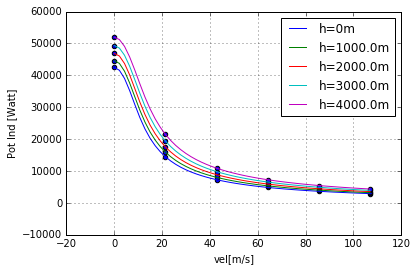

In [6]:
pot_ind = [[helicopter.potencia_inducida(vel,den) for vel in velocity] for den in density]# [Watt]
pot_ind_points = [[helicopter.potencia_inducida(vel,den) for vel in vel_points] for den in density]# [Watt]
[ plt.plot( velocity, pi, label = "h={}m".format( h ) ) for pi, h in zip( pot_ind, height ) ]
[ plt.scatter( vel_points, pi, marker='o') for pi, h in zip( pot_ind_points, height ) ]
plt.legend()
plt.ylabel("Pot Ind [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia parásita de la pala

Para el calculo de la potencia parasita de la pala, usamos el coeficiente de resistencia parasita promedio $\bar{{Cd}_0}$ obtenido en el TP 1. La contribución de la velocidad de avance se modela con un termino cuadratico, adimensionalizado con la velocidad de punta de pala, y multiplicado por el 4.6.

$${Pot}_0(v_{\infty}, h) = \frac{1}{8} ~ \rho(h) ~ n_{blades} ~ c ~ \bar{{Cd}_0} ~ r ~ (\omega \cdot r)^{3} ~ \left( 1 + 4.6 ~\left( \frac{v_{\infty}}{(\omega~r)} \right)^2 \right)$$

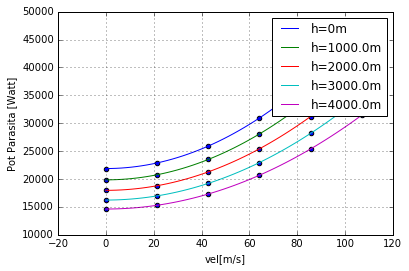

In [7]:
pot_0 = [[helicopter.potencia_parasita(vel,den) for vel in velocity] for den in density] # [Watt]
pot_0_points = [[helicopter.potencia_parasita(vel,den) for vel in vel_points] for den in density] # [Watt]

[ plt.plot( velocity, p0, label = "h={}m".format( h ) ) for p0, h in zip( pot_0, height ) ]
[ plt.scatter( vel_points, p0, marker='o') for p0, h in zip( pot_0_points, height ) ]
plt.legend()
plt.ylabel("Pot Parasita [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia parásita del fuselaje y otros elementos

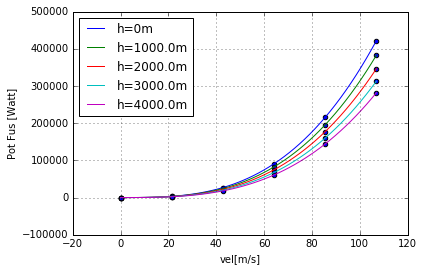

In [8]:
pot_fus = [[helicopter.potencia_fuselaje(vel,den) for vel in velocity] for den in density] # [Watt]
pot_fus_points = [[helicopter.potencia_fuselaje(vel,den) for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_fus, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_fus_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Fus [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia Necesaria base

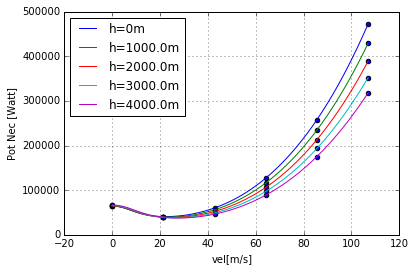

In [9]:
pot_nec = [[helicopter.potencia_necesaria_base(vel,den) for vel in velocity] for den in density] # [Watt]
pot_nec_points = [[helicopter.potencia_necesaria_base(vel,den) for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_nec, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Nec [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

###  Coeficiente de potencia reducida necesaria base

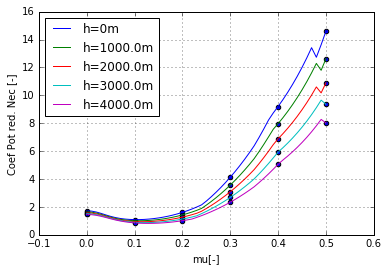

In [10]:
coef_pot_red_nec = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in velocity] for den in density] # [Watt]
coef_pot_red_nec_points = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in vel_points] for den in density] # [Watt]

[ plt.plot( mu, cprn, label = "h={}m".format( h ) ) for cprn, h in zip( coef_pot_red_nec, height ) ]
[ plt.scatter( mu_points, cprn, marker='o' ) for cprn, h in zip( coef_pot_red_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Coef Pot red. Nec [-]")
plt.xlabel("mu[-]")
plt.grid()
plt.show()

### Corrección por motor anticupla

Se considera de manera semejante como en el caso de vuelo a punto fijo. Se podría proceder haciendo una evaluación completa del rotor anticupla , o bien adoptar un cierto valor porcentual de la potencia suministrada al rotor principal ; en este caso se asume un 10% en lugar del 12% considerado en punto fijo , es decir:

$$ P_{{nec}_{a.c}} = 1.1 \cdot P_{nec}$$

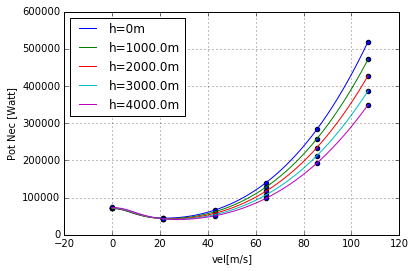

In [11]:
pot_nec_motor_anticupla = [[helicopter.potencia_necesaria_base(vel,den)
            + helicopter.potencia_motor_anticupla(vel, den)
            for vel in velocity] for den in density] # [Watt]
pot_nec_motor_anticupla_points = [[helicopter.potencia_necesaria_base(vel,den) 
                   + helicopter.potencia_motor_anticupla(vel, den)
                   for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_nec_motor_anticupla, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_nec_motor_anticupla_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Nec [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Corrección por pérdida aerodinámica de la pala en retroceso

Para determinar la potencia extra necesaria debido al aumento de Cd producido por la perdida de la pala en retroceso, debemos establecer el angulo de perdida del perfil que conforma la pala, y, dadas una altura y una velocidad, en que porcentaje de la pala comienza la perdida. Este valor, $r_p$, es función del azimuth $\Psi$. Para simplificar los calculos, calculamos solamente $r_p$ para $\Psi=90^o$, y a partir de este valor estimamos la contribución en el $C_p$ a partir de:

$$ \Delta C_p = \frac{k_p ~\sigma}{24\pi}(1-\mu)^2\cdot(1-r_p)\cdot\sqrt{(1-r_p)}$$

donde el factor $K_p$ se calcula a partir de:

$$k_p =1 \qquad \qquad \qquad \qquad si \frac{-B}{2\Theta_1} > 1$$

$$k_p =-\left( \frac{B/2\Theta_1+r_p}{1-r_p} \right) \qquad si \frac{-B}{2\Theta_1} < 1$$

y   
$$B = \Theta_0 - \alpha_{max} + (\Theta_{1_s}+\beta_{1_c}) - \mu \Theta_1$$


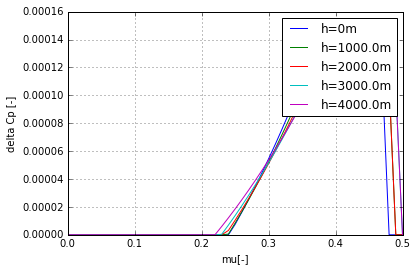

In [12]:
delta_cp_stall = [[helicopter.delta_cp_stall(vel, den) for vel in velocity] for den in density]
[ plt.plot( mu, cp, label = "h={}m".format( h ) ) for cp, h in zip( delta_cp_stall, height ) ]
plt.legend(loc='upper right')
plt.ylabel("delta Cp [-]")
plt.xlabel("mu[-]")
plt.grid()
plt.show()

### Correción por efectos de compresibilidad en la pala que avanza

El aumento de resistencia, y por ende, de potencia requerida $\Delta Cp_{comp}$, debido a los efectos de compresibilidad en la pala que avanza pueden ser contabilizados a través de la siguiente ecuación, la cual depende del mach de divergencia:

$$\Delta Cp_{comp} = \sigma~[0.012 \cdot \Delta M_{dD} + 0.1 (\Delta M_{dD})^3] $$

In [13]:
helicopter.mach_critico_simple(15*np.pi/180)

0.08770519377007546

In [14]:
helicopter.alpha_PTP(0.3*helicopter.rotor.tip_speed, density[0])*180/np.pi

-28.122695550405272

In [15]:
helicopter.alpha_tip_90(1,0.3*helicopter.rotor.tip_speed, density[0])*180/np.pi

-2.0374816783204097

In [16]:
helicopter.theta_0(0.3*helicopter.rotor.tip_speed, density[0])*180/np.pi

11.200157483156605

In [17]:
helicopter.aleteo_long(0.3*helicopter.rotor.tip_speed, density[0])*180/np.pi

-0.42519884765983912

In [18]:
helicopter.lambda_pasante(0.3*helicopter.rotor.tip_speed, density[0])*180/np.pi

-8.6616894118779086

In [19]:
helicopter.coeficiente_de_traccion(0.3*helicopter.rotor.tip_speed, density[0])

0.0024684992968073134

In [20]:
helicopter.coeficiente_de_traccion_pf(density[0])

0.002215958007536341

In [21]:
helicopter.rotor.solidity

0.030260108660588928

In [22]:
helicopter.rotor.area

46.566257107834716

In [23]:
helicopter.rotor.tip_speed**2

45755.776836000005

In [24]:
helicopter.weight

590

In [25]:
density[0]/Helicopter.GRAVITY

0.12496063416291654

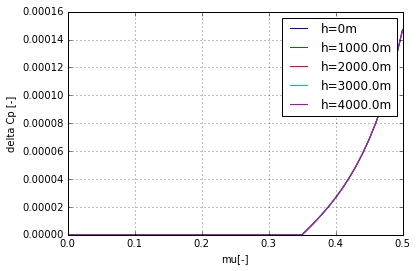

In [26]:
delta_cp_mach = [[helicopter.delta_cp_mach(vel, den) for vel in velocity] for den in density]
[ plt.plot( mu, cp, label = "h={}m".format( h ) ) for cp, h in zip( delta_cp_mach, height ) ]
plt.legend(loc='upper right')
plt.ylabel("delta Cp [-]")
plt.xlabel("mu[-]")
plt.grid()
plt.show()

In [27]:
helicopter.delta_mach_divergence(40,density[0])

-0.14858208664306144

In [28]:
helicopter.alpha_tip_90(radius=1, velocity=40, density=density[0])*1.24

-0.055140872273652539

In [29]:
helicopter.mach_critico_simple(helicopter.alpha_tip_90(radius=1, velocity=40, density=density[0]))

0.83499870673202592

### Potencia total necesaria

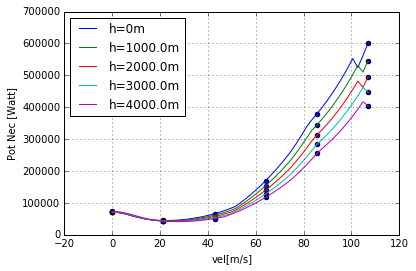

In [30]:
pot_nec = [[helicopter.potencia_necesaria(vel,den) for vel in velocity] for den in density] # [Watt]
pot_nec_points = [[helicopter.potencia_necesaria(vel,den) for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_nec, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Nec [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Coeficiente de potencia reducida total necesaria

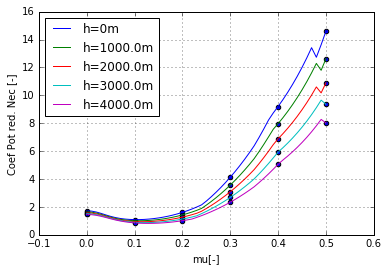

In [31]:
coef_pot_red_nec = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in velocity] for den in density] # [Watt]
coef_pot_red_nec_points = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in vel_points] for den in density] # [Watt]

[ plt.plot( mu, cprn, label = "h={}m".format( h ) ) for cprn, h in zip( coef_pot_red_nec, height ) ]
[ plt.scatter( mu_points, cprn, marker='o' ) for cprn, h in zip( coef_pot_red_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Coef Pot red. Nec [-]")
plt.xlabel("mu[-]")
plt.grid()
plt.show()

In [32]:
helicopter.potencia_compressibilidad(0.4*helicopter.rotor.tip_speed,density[0])

14813.840710502594

## 2) Velocidad de mínima potencia

C:\Users\enri\PYTHON_PROJECTS\Helicopteros\helicopter.py:382: RuntimeWarning: invalid value encountered in greater
  if dcp > 0:


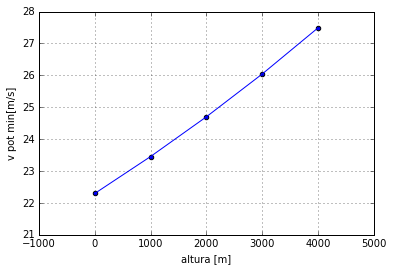

In [33]:
v_pot_min = [helicopter.velocidad_de_potencia_minima(den, vel_guess=100) for den in density]
plt.plot( height, v_pot_min )
plt.scatter( height, v_pot_min, marker='o')
plt.ylabel("v pot min[m/s]")
plt.xlabel("altura [m]")
plt.grid()
plt.show()

## 3) Velocidad de maximo alcance

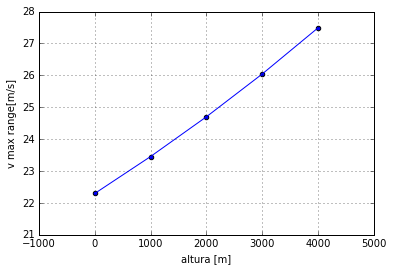

In [34]:
v_max_range = [helicopter.velocidad_de_maximo_alcance(den, vel_guess=90) for den in density]
plt.plot( height, v_pot_min )
plt.scatter( height, v_pot_min, marker='o')
plt.ylabel("v max range[m/s]")
plt.xlabel("altura [m]")
plt.grid()
plt.show()

Grafico de velocidad de potencia mínima y velocida de maximo alcance

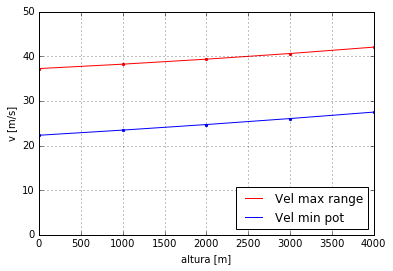

In [35]:
plt.plot( height, v_max_range, color=[1,0,0], label='Vel max range')
plt.scatter(height, v_max_range, color=[1,0,0], marker='.')
plt.plot( height, v_pot_min, color=[0,0,1], label='Vel min pot')
plt.scatter( height, v_pot_min, color=[0,0,1], marker='.')
plt.legend(loc=4)
plt.ylabel("v [m/s]")
plt.xlabel("altura [m]")
axes = plt.gca()
axes.set_xlim([height[0],height[-1]])
axes.set_ylim([0,50])
plt.grid()
plt.show()

## 4) Velocidad de descenso en autorotación

Calculamos la velocidad de descenso en autorotación en función de la velocidad de avance, para las distintas alturas estudiadas. Para esto, toda la energia potencial que pierde la aeronave en el descenso, se convierte en energia para propulsar la aeronave. Tambien se asume que esta energia es la misma que en el caso de vuelo horizontal. Por ende, la razon de disminución de energia potencial en función del timpo ($W \cdot g \cdot  v_{h_{autorot}}$) es igual a la potencia necesaria para una determinada altura y velocidad de avance $P_{nec}(V_{\infty},h)$

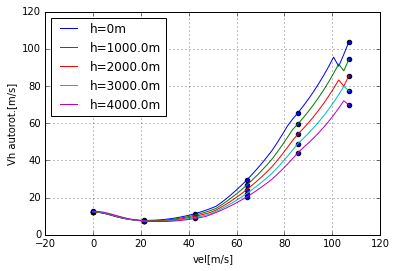

In [36]:
v_h_autorot = [[helicopter.velocidad_autorotacion(vel,den) for vel in velocity] for den in density]
v_h_autorot_points = [[helicopter.velocidad_autorotacion(vel,den) for vel in vel_points] for den in density]

[ plt.plot( velocity, vh, label = "h={}m".format( h ) ) for vh, h in zip( v_h_autorot, height ) ]
[ plt.scatter( vel_points, vh, marker='o') for vh, h in zip( v_h_autorot_points, height ) ]
plt.legend(loc=2)
plt.ylabel("Vh autorot.[m/s]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

## 5) Estimación de la velocidad de ascenso 

### Potencia Disponible

La potencia disponible de un turbomotor disminuye linealmente con la altura, segun la función:
$$Pot_{disp} = P_{h_0} \cdot \left( 1 - 0.037\left(\frac{h}{304.8}\right) \right)$$

Siendo $P_{h_0}$ la potencia máxima del motor. Este helicóptero posee un motor Lycoming HIO-360-D1A con una potencia máxima de 131 HP (97.7 Kw). La potencia disponible para la planta motriz en función de la altura disminuye un 3.7%/K.ft


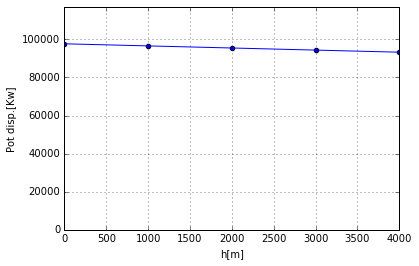

In [37]:
pot_h_0 = 131 * 745.6998715822701 # [watt]
engine_manufacturer = Helicopter.EngineType.LYCOMING
helicopter.engine = Helicopter.Helicopter.Engine(engine_type=engine_manufacturer,
                                                potencia_maxima=pot_h_0)
pot_disp = [helicopter.engine.potencia_disponible(h) for h in height]
plt.plot(height, pot_disp)
plt.scatter(height, pot_disp, marker='o')
plt.axis([height[0], height[-1], 0, 1.2*pot_disp[0]])
plt.ylabel("Pot disp.[Kw]")
plt.xlabel("h[m]")
plt.grid()
plt.show()

### Potencia disponible vs potencia necesaria

Graficamos la potencial disponible y necesaria para cada altura

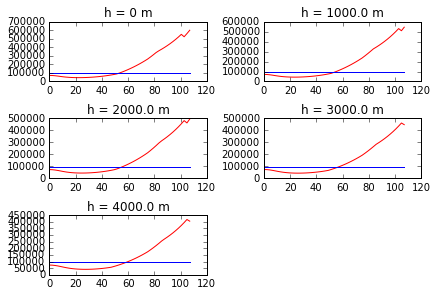

In [38]:
plt.subplot(3, 2, 1)
plt.plot(velocity, pot_nec[0], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[0]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[0]))
plt.subplot(3, 2, 2)
plt.plot(velocity,  pot_nec[1], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[1]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[1]))
plt.subplot(3, 2, 3)
plt.plot(velocity,  pot_nec[2], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[2]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[2]))
plt.subplot(3, 2, 4)
plt.plot(velocity,  pot_nec[3], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[3]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[3]))
plt.subplot(3, 2, 5)
plt.plot(velocity,  pot_nec[4], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[4]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[4]))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Calculamos el excedente de pontencia para cada caso: $$\Delta Pot = {Pot}_{disp} - {Pot}_{nec}$$

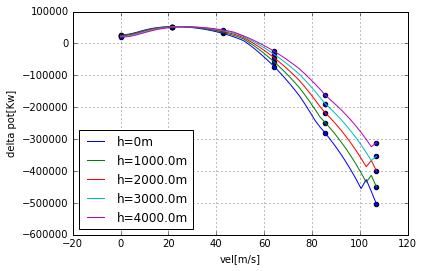

In [39]:
delta_pot = [[helicopter.potencia_excedente(vel, h) for vel in velocity] for h in height]
delta_pot_points = [[helicopter.potencia_excedente(vel, h) for vel in vel_points] for h in height]
[ plt.plot( velocity, dp, label="h={}m".format( h ) ) for dp, h in zip( delta_pot, height ) ]
[ plt.scatter( vel_points, dp, marker='o' ) for dp in delta_pot_points]
plt.legend(loc=3)
plt.ylabel("delta pot[Kw]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

###  Tracción necesaria

La tracción producida por el rotor debe ser tal que debe vencer tanto el peso 
de la aeronave, como la resistencia (solo consideramos la del fuselaje).
$$ T = \sqrt{W_{max}^2 + D_f^2}$$
Donde: $D_f = 0.5~f~\rho~v^2$


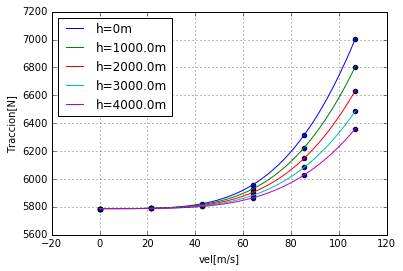

In [40]:
traccion_nec = [ [ helicopter.traccion_necesaria(vel, den) for vel in velocity] for den in density]
traccion_nec_points = [ [ helicopter.traccion_necesaria(vel, den) for vel in vel_points] for den in density]
[ plt.plot( velocity, tr, label="h={}m".format( h ) ) for tr, h in zip( traccion_nec, height ) ]
[ plt.scatter( vel_points, tr, marker='o' ) for tr in traccion_nec_points]
plt.legend(loc=2)
plt.ylabel("Traccion[N]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Velocidad de Ascenso

Calculamos la velocidad de ascenso a partir de $\Delta Pot$, la tracción $T$, y la velocidad inducida en punto fijo ${V_i}_0$

$$ V_{asc} = \frac{\Delta P}{T} \cdot \frac{2 {V_i}_0 + \frac{\Delta P}{T}}{{V_i}_0 + \frac{\Delta P}{T}} $$

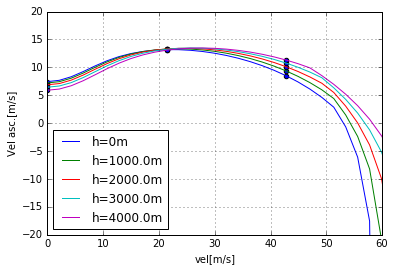

In [41]:
v_asc = [ [ helicopter.velocidad_de_ascenso(vel, h) for vel in velocity] for h in height]
v_asc_points = [ [ helicopter.velocidad_de_ascenso(vel, h) for vel in vel_points] for h in height]
[ plt.plot( velocity, va, label="h={}m".format( h ) ) for va, h in zip( v_asc, height ) ]
[ plt.scatter( vel_points, va, marker='o' ) for va in v_asc_points]
plt.axis([0,60,-20,20])
plt.legend(loc=0)
plt.ylabel("Vel asc.[m/s]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Techo practico

Definimos techo práctico como la altura para la cual la velocidad de ascenso es de $0.5~m/s$

c:\users\enri\appdata\local\programs\python\python35-32\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\enri\appdata\local\programs\python\python35-32\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


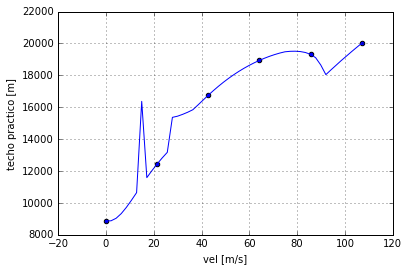

In [42]:
techo_practico = [helicopter.techo_practico(vel, h_guess=30000) for vel in velocity]
techo_practico_points = [helicopter.techo_practico(vel, h_guess=30000) for vel in vel_points]
plt.plot(velocity, techo_practico)
plt.scatter(vel_points, techo_practico_points)
plt.ylabel("techo practico [m]")
plt.xlabel("vel [m/s]")
plt.grid()
plt.show()

In [43]:
print("Techo practico vuelo en punto fijo: {:.1f} m".format(float(techo_practico[0])))
print("Techo practico maximo: {:.1f} m".format(float(max(techo_practico))))
print("Velocidad de avance para techo maximo: {:.2f} m/s".format(velocity[techo_practico.index(max(techo_practico))]))


Techo practico vuelo en punto fijo: 8875.4 m
Techo practico maximo: 20011.8 m
Velocidad de avance para techo maximo: 106.95 m/s


La expresión dada para la potencia reducida subestima la potencia necesaria para el vuelo del helicóptero a velocidad de avance creciente por no tener en cuenta la perdida de sustentación en la pala retrocederte y el incremento de resistencia aerodinámica por efecto de compresibilidad del aire en la pala que avanza.

## 6) Estimacion el tiempo de punto fijo equivalente para autorotación

 Una forma de cuantificar la capacidad de la aeronave de entrar en autorotación es a través del tiempo de punto fijo equivalente $t_{equiv}$, que es el tiempo que tarda en disiparse la energía cinetica almacenada en el rotor$J\Omega^2$, antes de que las palas entren en perdida. Usando la definición de $t_{equiv}$ propuesta en '"High Energy Rotor System", Wood, AHS 32nd Forum, 1976', tenemos:
 
 $$ t_{equiv}=\frac{J\Omega^2\left(1-\frac{C_{T_0}/\sigma}{0.8\cdot (C_T/\sigma)_{max}}\right)}{1100 \dot {h.p.}_{OGE}}$$
 
donde  ${h.p.}_{OGE}$ es la potencia disponible fuera del efecto suelo, en $HP$, y $(C_T/\sigma)_{max}$ coresponde al coeficiente de tracción maximo dispoble. Este valor fue estimado de las graficas disponibles en el capitulo 1 de "Helicopter Performance, Stability and Control", Prouty, usando un angulo de alabeo de $5^o$,  $\sigma=0.5$, y $M_{tip}=0.6$

In [45]:
print(helicopter.tiempo_de_punto_fijo_equivalente(height[0]))
print(helicopter.tiempo_de_punto_fijo_equivalente(height[1]))
print(helicopter.tiempo_de_punto_fijo_equivalente(height[2]))
print(helicopter.tiempo_de_punto_fijo_equivalente(height[3]))

0.7538780335190344
0.7609056036659791
0.7678900611675294
0.774797176868265


## 7) Calidad de la autorotación en vase al tiempo de punto fijo equivalente

Nos basamos devueta en los resultados de '"High Energy Rotor System", Wood, AHS 32nd Forum, 1976" para relacionar el tiempo de punto fijo equivalente con la apreciación de los pilotos de la capacidad de la aeronave de entrar en autorotación. Los resultados obtenidos ponen al Robinson R22-Beta definitivamente en la zona de pobre performance de entrada y salida de autorotación.

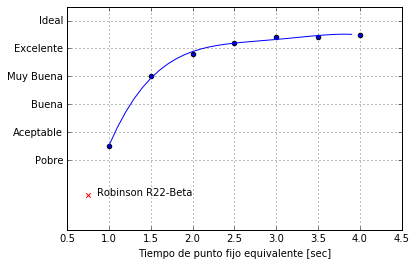

In [106]:
labels = ['Pobre','Aceptable','Buena','Muy Buena','Excelente','Ideal']
aproximate_curve = np.array([[1.0,1.0],[1.5,3.5],[2.0, 4.3],[2.5, 4.7],[3.0,4.9],[3.5,4.9],[4.0,5.0]])
coeff = np.polyfit(aproximate_curve[:,0],aproximate_curve[:,1],4)
func = lambda x: coeff[0]*x**4+coeff[1]*x**3+coeff[2]*x**2+coeff[3]*x+coeff[4]
time = np.arange(1.0,4.0,0.1)
plt.plot(time,[func(t) for t in time])
plt.scatter(aproximate_curve[:,0],aproximate_curve[:,1])
plt.scatter(helicopter.tiempo_de_punto_fijo_equivalente(height[0]),
            func(helicopter.tiempo_de_punto_fijo_equivalente(height[-1])),
           color=[1,0,0], marker="x")
plt.xlabel("Tiempo de punto fijo equivalente [sec]")
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5], labels)
plt.annotate('Robinson R22-Beta',xy=(helicopter.tiempo_de_punto_fijo_equivalente(height[0])+0.1,
            func(helicopter.tiempo_de_punto_fijo_equivalente(height[-1]))))
plt.grid()

## 8) Comentar los resultados obtenidos en base a la comparación con los datos informados por el fabricante.

No dispongo de datos del fabricante sobre los parametros calculados